In [2]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
import base64
from PIL import Image
from cStringIO import StringIO
import skimage
import scipy
%matplotlib inline

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import scipy.io as sio
import caffe, cv2
import os

# flask
from flask import Flask, Response, request, jsonify
from app import app

# import data science tools
import numpy as np
#import caffe
from scipy import misc
from selectivesearch import selective_search
from scipy.spatial import distance
from sklearn.externals import joblib
from math import sqrt

# Misc
from cStringIO import StringIO
from PIL import Image
import json
import operator
import skimage
import scipy
import logging
from datetime import datetime

import xml.etree.cElementTree as ET
%matplotlib inline

In [5]:
# CLASSES = ('__background__',
#            'coke cropped', 'drpepper cropped', 'dietpepsi cropped',
#            'dietcoke cropped', 'pepsi cropped', 'dietdrpepper cropped',
#            'mountaindew cropped', 'cokezero cropped', 'sprite cropped',
#            'sunkist cropped')

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel'),
        'vgg16_finetune': ('VGG16',
                'vgg16_faster_rcnn_iter_100000.caffemodel'),
        'vgg16_finetune2': ('VGG16',
                'vgg16_faster_rcnn_iter_2000.caffemodel')}

pics_dir = '/home/ai2-jedi/data/SmartCooler/JPEGImages'

In [6]:
def print_bbox(filename, im, class_name, dets, thresh):
    """Print detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if class_name == 'bottle':
    #if True:
        #print 'Print: ' + str(len(inds))
        if len(inds) == 0:
            return
        for i in inds:
            bbox = dets[i, :4]
            score = dets[i, -1]
            bboxes.append(bbox)
            #print "Appened"
            classes.append(class_name)
            scores.append(score)
            #print '{filename: %s, class: %s, bbox: %s, score: %s}' % (filename, class_name, bbox, score)

In [7]:
def vis_detections(im, class_name, dets, thresh):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if class_name == 'bottle':
        print 'Vis: ' + str(len(inds))
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        #print bbox
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [8]:
def demo(net, image_dir):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    #im_file = pics_dir +"/" + image_name
    #im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(image_dir)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    #print ('Detection took {:.3f}s for '
    #       '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.6
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        #vis_detections(im, cls, dets, thresh=CONF_THRESH)
        print_bbox(image_dir, im, cls, dets, thresh=CONF_THRESH)
        #saveXML(image_name, cls, dets, thresh=CONF_THRESH)
        

In [9]:
##Save the output to XML
def saveXML(image_dir,folder,bbox,file_name):
    if bbox == []:
        print 'No XML created for ' + image_dir
        return
    img = cv2.imread(image_dir)
    img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
    candidates = list()
    img_shape = img.shape
    candidates.append(img.shape)
    for box in bbox:
        x = box[0]
        y = box[1]
        x2 = box[2]
        y2 = box[3]
        cls = folder
        region = (x,y,x2,y2,cls)
        candidates.append(region)
    #print candidates
    
    root = ET.Element("annotation")
    
    folder = ET.SubElement(root, "folder")
    folder.text = "faces"
    
    filename = ET.SubElement(root, "filename")
    filename.text = str(file_name)
    
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(candidates[0][1])
    ET.SubElement(size, "height").text = str(candidates[0][0])
    ET.SubElement(size, "depth").text = str(candidates[0][2])
    
    seg = ET.SubElement(root, "segmented")
    seg.text = '0'
    
    for item in candidates[1:]:
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text = str(item[4])
        ET.SubElement(obj, "pose").text = 'Unspecified'
        ET.SubElement(obj, "truncated").text = '0'
        ET.SubElement(obj, "difficult").text = '0'
        
        bbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bbox, "xmin").text = str(item[0])
        ET.SubElement(bbox, "ymin").text = str(item[1])
        ET.SubElement(bbox, "xmax").text = str(item[2])
        ET.SubElement(bbox, "ymax").text = str(item[3])

    tree = ET.ElementTree(root)
    os.chdir('/home/ai2-jedi/data/SmartCooler_China/Annotations')
    index = file_name.find(".")
    fileToWrite = file_name[:index] + ".xml"
    #print "Wrote " + fileToWrite
    tree.write(fileToWrite)


In [10]:
#if __name__ == '__main__':
cfg.TEST.HAS_RPN = True  # Use RPN for proposals

#args = parse_args()

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                       'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')

# prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16_finetune2'][0],
#                        'faster_rcnn_end2end', 'test.prototxt')

caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)

counter = 0
folders = '/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2'
for f in os.listdir(folders):
    if f != 'multiplecans':
        can_folder = folders + "/" + f
        f = f + " cropped"
        print can_folder
        for image in os.listdir(can_folder):
            image_dir = can_folder + "/" + image
            bboxes = []
            classes = []
            scores = []
            demo(net, image_dir)
            saveXML(image_dir,f,bboxes,image)

#plt.show()



Loaded network /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel
/media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0067.jpg
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0416.jpg
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0027.jpg
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0331.jpg
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0457.jpg
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0023.jpg
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0213.jpg
No XML created for /media/ai2-jedi/data_disk/data_sets/Smartcooler_data2/mirinda/mirinda0317.jpg
No XML crea

KeyboardInterrupt: 

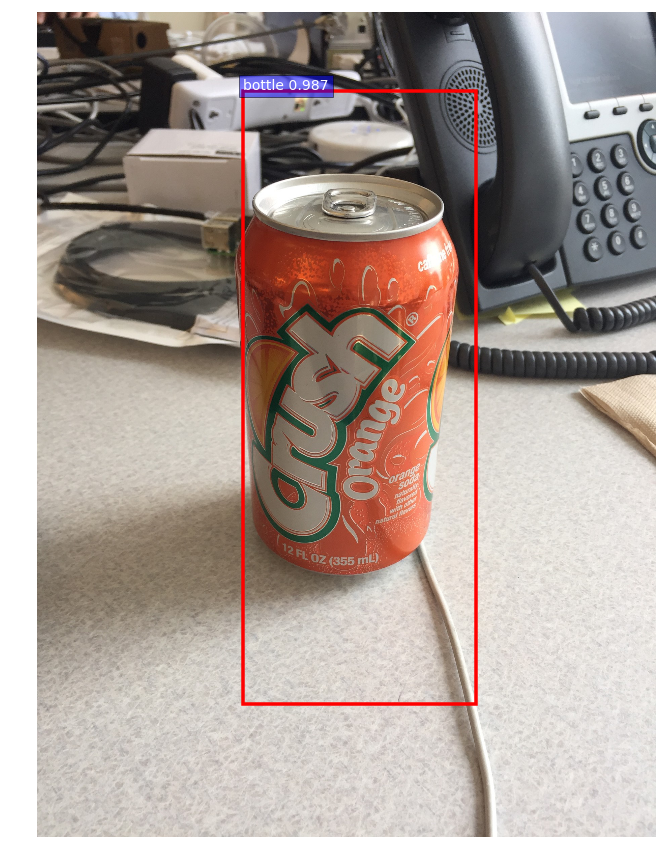

In [26]:
##Just to get the bounding boxes on the same image
im_name = 'crush1.JPG'
im_file = os.path.join(cfg.DATA_DIR, 'demo', im_name)
im = cv2.imread(im_file)
im = im[:, :, (2, 1, 0)]
fig, ax = plt.subplots(figsize=(12, 12))
#Print all the bounding boxes found
for i in range(len(bboxes)):
    bbox = bboxes[i]
    class_name = classes[i]
    score = scores[i]

    ax.imshow(im, aspect='equal')
    ax.add_patch(plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5))
    ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    plt.axis('off')
    plt.tight_layout()
plt.show()


##Create faces dataset for faster rcnn

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
face_cascade = cv2.CascadeClassifier('/home/ai2-jedi/Desktop/haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier('/home/ai2-jedi/Desktop/haarcascade_profileface.xml') 
eye_cascade = cv2.CascadeClassifier('/home/ai2-jedi/Desktop/haarcascade_eye.xml') 

In [43]:
face_data_dir = '/media/ai2-jedi/data_disk/data_sets/faces/'
def getFaceBbox(image_name, folder):
    imgface_data_dir = face_data_dir + folder + "/" + image_name
    img = cv2.imread(imgface_data_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    profiles = profile_cascade.detectMultiScale(gray, 1.2, 6)
    #print profiles
    result = []
    for box in faces:
        x = box[0]
        y = box[1]
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        result.append([x,y,x2,y2])
    return result


[[247, 153, 395, 301]]


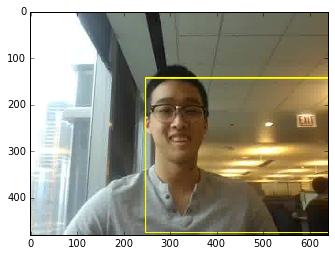

In [44]:
folder = 'Cane'
image_name = 'Cane014.jpg'
faces = getFaceBbox(image_name,folder)
print faces
imgface_data_dir = face_data_dir + folder + "/" + image_name
img = cv2.imread(imgface_data_dir)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y-10),(x+w+20,y+h+20),(255,255,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y-10:y+h+20, x-14:x+w+20]

for (x,y,w,h) in profiles:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    #roi_color = img[y:y+h, x:x+w]
    #eyes = eye_cascade.detectMultiScale(roi_gray)
    #for (ex,ey,ew,eh) in eyes:
    #    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.imshow(img)

In [50]:
folders = '/media/ai2-jedi/data_disk/data_sets/faces'
for f in os.listdir(folders):
    person_folder = folders + "/" + f
    print person_folder
    for image in os.listdir(person_folder):
        image_dir = person_folder + "/" + image
        bboxes = getFaceBbox(image, f)
        saveXML(image_dir,f,bboxes,image)


/media/ai2-jedi/data_disk/data_sets/faces/Jack
/media/ai2-jedi/data_disk/data_sets/faces/Cane
/media/ai2-jedi/data_disk/data_sets/faces/Rachel
/media/ai2-jedi/data_disk/data_sets/faces/Vasu
/media/ai2-jedi/data_disk/data_sets/faces/Shantanu
/media/ai2-jedi/data_disk/data_sets/faces/Paul
/media/ai2-jedi/data_disk/data_sets/faces/Kay
/media/ai2-jedi/data_disk/data_sets/faces/Scott
/media/ai2-jedi/data_disk/data_sets/faces/Spencer


# Creating train.txt file

In [10]:
##Create the train.txt file for all the images that have annotations
annotations = os.listdir('/home/ai2-jedi/data/SmartCooler_China/Annotations/')
#print annotations
trainFile = open('/home/ai2-jedi/data/SmartCooler_China/ImageSets/Main/train.txt',"w")
for file_name in annotations:
    index = file_name.find(".")
    name = file_name[:index]
    trainFile.write(name + "\n")
trainFile.close()

In [11]:
##Removes the images that had no objects identified within them thus no .xml file
train_imgs_dir = '/home/ai2-jedi/data/SmartCooler_China/JPEGImages/'
for img in os.listdir(train_imgs_dir):
    index = img.find(".")
    name = img[:index] + '.xml'
    if name not in os.listdir('/home/ai2-jedi/data/SmartCooler_China/Annotations/'):
        #print name
        os.chdir(train_imgs_dir)
        os.remove(img)
        print "Removed " + str(img)

Removed marinda106.jpg
Removed marinda120.jpg
Removed sunkist_close010.jpg
Removed schweppes098.jpg
Removed schweppes217.jpg
Removed schweppes084.jpg
Removed sprite_close096.jpg
Removed marinda158.jpg
Removed marinda182.jpg
Removed marinda192.jpg
Removed schweppes085.jpg
Removed marinda172.jpg
Removed sprite_close004.jpg
Removed marinda087.jpg
Removed marinda183.jpg
Removed mountaindew_close112.jpg
Removed schweppes012.jpg
Removed schweppes005.jpg
Removed marinda214.jpg
Removed marinda213.jpg
Removed schweppes087.jpg
Removed schweppes200.jpg
Removed schweppes101.jpg
Removed schweppes123.jpg
Removed marinda209.jpg
Removed schweppes046.jpg
Removed drpepper_close074.jpg
Removed sunkist_close009.jpg
Removed dietpepsi_close003.jpg
Removed marinda121.jpg
Removed pepsi_close089.jpg
Removed marinda211.jpg
Removed schweppes053.jpg
Removed marinda054.jpg
Removed marinda023.jpg
Removed schweppes135.jpg
Removed schweppes099.jpg
Removed sprite_close043.jpg
Removed marinda166.jpg
Removed schweppes08

# bullshit

In [48]:
#Print all the bounding boxes found
for box in bboxes:
    print box

[    0.           564.86071777   583.71179199  1881.24353027]
[  606.18151855   720.84655762  1371.19055176  1940.67370605]
[ 1512.078125     283.12493896  2180.79711914  1918.91479492]


In [39]:
cropped_images_rcnn = list()
for bbox in bboxes:
    x_start = int(bbox[0])
    x_end = int(bbox[2])
    y_start = int(bbox[1])
    y_end = int(bbox[3])
    new_img = image[y_start:y_end, x_start:x_end]
    cropped_images_rcnn.append(new_img)
print len(cropped_images_rcnn)
print cropped_images_rcnn[0].shape

NameError: name 'image' is not defined

In [73]:
### Load the Alexnet 2012 model for feature extraction
# Model prototxt file
MODEL_PROTOTXT = 'app/models/featext_caffe_20151101/deploy.prototxt'

# Model caffemodel file
MODEL_TRAINED = 'app/models/featext_caffe_20151101/bvlc_reference_caffenet.caffemodel'

# Path to the mean image (used for input processing)
MEAN_PATH = 'app/models/featext_caffe_20151101/ilsvrc_2012_mean.npy'

# load caffe model
NET = caffe.Classifier(MODEL_PROTOTXT,
                       MODEL_TRAINED,
                       mean=np.load(MEAN_PATH).mean(1).mean(1),
                       channel_swap=(2, 1, 0),
                       raw_scale=255)
                       #image_dims=(256, 256))

LAYER_NAME = 'fc7'

### Load the classification models
MODEL_INDEX = dict()
# load logistic regression model (can or bottle classification)
LR_CB_MODEL = joblib.load('app/models/can_logreg_20160101/lr_can_other.pkl')

# load logistic regression model (brand classification)
LR_SODA_MODEL = joblib.load('app/models/brand_logreg_20160101/Brand_Classification_Log_Reg.pkl')

### Load the can classifcation model from caffe
CAN_MODEL_PROTOTXT = 'app/models/brand_caffe_20160201/deploy.prototxt'
CAN_MODEL_TRAINED = 'app/models/brand_caffe_20160201/snapshot_iter_154200.caffemodel'
CAN_MEAN_PATH = 'app/models/brand_caffe_20160201/mean_image.npy'
CAN_NET = caffe.Classifier(CAN_MODEL_PROTOTXT,
                           CAN_MODEL_TRAINED,
                           mean=np.load(CAN_MEAN_PATH).mean(1).mean(1),
                           channel_swap=(2, 1, 0),
                           raw_scale=255)
caffe.set_mode_gpu()

In [74]:
# load label convert index dictionary
try:
    with open('app/label_dict.json') as json_data:
        temp = json.loads(json_data.read())
        LABELS = dict((y, x) for x, y in temp.iteritems())
except Exception, e:
    logging.warning(e)

try:
    with open('app/models/brand_caffe_20160201/label_dict_caffe.json') as json_data:
        temp = json.loads(json_data.read())
        CAFFE_LABELS = dict((int(x), y) for x, y in temp.iteritems())
except Exception, e:
    logging.warning(e)

try:
    with open('app/models/model_index.json') as json_data:
        MODEL_INDEX = json.loads(json_data.read())
except Exception, e:
    logging.warning(e)
    
print LABELS
print CAFFE_LABELS
print MODEL_INDEX

{0: u'coke', 1: u'coke_zero', 2: u'diet_coke', 3: u'diet_dr_pepper', 4: u'diet_pepsi', 5: u'dr_pepper', 6: u'mountain_dew', 7: u'pepsi', 8: u'sprite', 9: u'sunkist'}
{0: u'CokeZero cropped', 1: u'DietDrPepper cropped', 2: u'Sunkist cropped', 3: u'Coke cropped', 4: u'Sprite cropped', 5: u'DietCoke cropped', 6: u'DietPepsi cropped', 7: u'Pepsi cropped', 8: u'MountainDew cropped', 9: u'DrPepper cropped'}
{u'brand_SVM_20160101': {u'date': u'20160101', u'model_use': u'brand', u'name': u'brand_SVM_20160101', u'model_technique': u'SVM'}, u'can_logreg_20160101': {u'date': u'20160101', u'model_use': u'can', u'name': u'can_logreg_20160101', u'model_technique': u'logreg'}, u'brand_caffe_20160201': {u'date': u'20160201', u'model_use': u'brand', u'name': u'brand_caffe_20160201', u'model_technique': u'caffe'}, u'brand_logreg_20160101': {u'date': u'20160101', u'model_use': u'brand', u'name': u'brand_logreg_20160101', u'model_technique': u'logreg'}, u'featext_caffe_20151101': {u'date': u'20151101', u'

In [86]:
def predict_can_bottle(img):
    print img.shape
    print type(img)
    forward_pass = NET.predict([img])
    print 'Passed forward'
    result = NET.blobs[LAYER_NAME].data[0].reshape(1, -1)
    raw_predictions = LR_CB_MODEL.predict_proba([result[0][:4096]])

    return raw_predictions[0][1]

In [76]:
# This function runs a can (represented as a feature vector of size 4096) through a pretrained ImageNet deep net and determines the top brand predictions according to a loaded log reg model
def predict_brands(img, top=len(LABELS), model_flag=''):
    #if model_flag == 'caffe_model':
    CAN_NET.predict([img])
    out = CAN_NET.forward()
    raw_predictions_caffe =  out['prob'][0].tolist()
    labeled_predictions_caffe = sorted({str(CAFFE_LABELS[i]): x for i, x in enumerate(raw_predictions_caffe)}.items(),
                                       key=operator.itemgetter(1), reverse=True)

    forward_pass = NET.predict([img])
    result = NET.blobs[LAYER_NAME].data[0].reshape(1, -1)
    raw_predictions = LR_SODA_MODEL.predict_proba([result[0][:4095]])
    labeled_predictions = sorted({str(LABELS[i]): x for i, x in enumerate(raw_predictions[0])}.items(),
                                 key=operator.itemgetter(1), reverse=True)

    return (labeled_predictions_caffe[:top], labeled_predictions[:top])

[  592.7824707    388.58514404  1369.44763184  1943.        ]
[<type 'numpy.float32'>]
[    0.           705.21209717   579.29553223  1922.26611328]
[<type 'numpy.float32'>]
[ 1539.84191895   494.86730957  2124.18017578  1914.47644043]
[<type 'numpy.float32'>]
List Storage Model 1[{'coordinates': {'x2': '1369.45', 'y1': '388.585', 'x1': '592.782', 'y2': '1943.0'}, 'classification': [{'description': 'CokeZero cropped', 'probability': 0.8719199299812317}, {'description': 'DrPepper cropped', 'probability': 0.10629190504550934}, {'description': 'Pepsi cropped', 'probability': 0.021336475387215614}]}, {'coordinates': {'x2': '579.296', 'y1': '705.212', 'x1': '0.0', 'y2': '1922.27'}, 'classification': [{'description': 'Sprite cropped', 'probability': 0.9996305704116821}, {'description': 'MountainDew cropped', 'probability': 0.00036495248787105083}, {'description': 'Coke cropped', 'probability': 2.371509253862314e-06}]}, {'coordinates': {'x2': '2124.18', 'y1': '494.867', 'x1': '1539.84', 'y2':

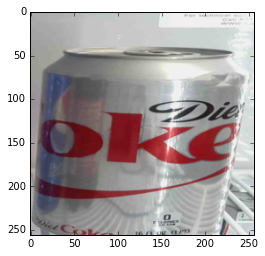

In [113]:
top_dict = {}
top_dict['models'] = {}  # populated below

list_storage = []  # used for storing classification/location/etc.
list_storage_model2 = []

can_probability_storage = [] #used with meta flag to return parameters

model_flag = ''

for index, crop in enumerate(cropped_images_rcnn):

            small_can = scipy.misc.imresize(crop, (256, 256))  # resize the image to 256x256
            small_can = skimage.img_as_float(small_can)   # caffe default is skimage
            #can_probability = predict_can_bottle(small_can)
            #can_probability_storage.append(can_probability)
            
            plt.imshow(small_can)
            
            # retreive top 3 predictions and their probabilities
            guesses_model1,guesses_model2 = predict_brands(small_can, top=3, model_flag=model_flag)
            
            nested_dict = []  # used to store predictions in API format
            for guess in guesses_model1:
                nested_dict.append(dict(description= guess[0], probability= guess[1]))

            #print "Nested_dict model 1:" + str(nested_dict)
            
            # stores a dictionary for each unique object in a separate slot in the list.
            # The classification dictionary stores the predictions.  The coordinates dict stores the location
            print bboxes[index]
            print[type(bboxes[index][0])]
            list_storage.append(dict(classification = nested_dict, 
                                     coordinates=dict(x1 = str(bboxes[index][0]), y1 = str(bboxes[index][1]), 
                                                    x2 = str(bboxes[index][2]), y2 = str(bboxes[index][3]))))

            nested_dict_model2 = []  # used to store predictions in API format
            for guess in guesses_model2:
                nested_dict_model2.append(dict(description= guess[0], probability= guess[1]))
                
            #print "Nested_dict model 2:" + str(nested_dict_model2)

            # stores a dictionary for each unique object in a separate slot in the list.
            # The classification dictionary stores the predictions.  The coordinates dict stores the location
            list_storage_model2.append(dict(classification = nested_dict_model2, 
                                            coordinates=dict(x1 = str(bboxes[index][0]), y1 = str(bboxes[index][1]), 
                                                            x2 = str(bboxes[index][2]), y2 = str(bboxes[index][3]))))

print "List Storage Model 1" + str(list_storage)
print " " 
print "List Storage Model 2" + str(list_storage_model2)

In [116]:
if list_storage_model2 or list_storage:
    top_dict['models'] = dict(deep_learning= list_storage, log_reg = list_storage_model2)
    
# if 'meta_flag' in payload_dict: #append the meta data
#     if payload_dict['meta_flag'] == True:
#         top_dict['meta'] = dict(can_probabilities=can_probability_storage, 
#                                 selective_search_total = ssearch_count, 
#                                 cleaned_ss_count = len(cropped_images), 
#                                 can_count = len(list_storage))

# answer returns via Response() in dictionary format
answer = json.dumps(top_dict)
print answer
# if list_storage:  # something was added
#     resp = Response(answer, status=200, mimetype='application/json')
#     logging.debug(str(datetime.now()) + " - Found " + str(len(list_storage)) + " items")
# else:
#     #top_dict['models'] = []
#     #answer = {'models':[]}  # send back empty dictionary
#     resp = Response(answer, status = 200, mimetype='application/json')
#     logging.warning(str(datetime.now()) + " - Dictionary returned to poster is empty")  # the log is not returned
# return resp


{"models": {"log_reg": [{"coordinates": {"x2": "1369.45", "y1": "388.585", "x1": "592.782", "y2": "1943.0"}, "classification": [{"description": "coke_zero", "probability": 0.99999978342605278}, {"description": "pepsi", "probability": 1.7975139958919416e-07}, {"description": "diet_dr_pepper", "probability": 3.5438975558092029e-08}]}, {"coordinates": {"x2": "579.296", "y1": "705.212", "x1": "0.0", "y2": "1922.27"}, "classification": [{"description": "pepsi", "probability": 0.97042541168843555}, {"description": "coke_zero", "probability": 0.029552627093542491}, {"description": "sprite", "probability": 2.1927162966571981e-05}]}, {"coordinates": {"x2": "2124.18", "y1": "494.867", "x1": "1539.84", "y2": "1914.48"}, "classification": [{"description": "pepsi", "probability": 0.94783002677766393}, {"description": "diet_dr_pepper", "probability": 0.040176153608278226}, {"description": "diet_coke", "probability": 0.0097926518656218358}]}], "deep_learning": [{"coordinates": {"x2": "1369.45", "y1":